<a href="https://colab.research.google.com/github/SalehMehrabani/PyTorch-Deep-Learning/blob/main/CNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolution Neural Network
* PyTorch Convolutional Neural Network

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import ToTensor


In [2]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##Get Data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

    # Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...") 
  zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## Data Preparation and Data Exploration

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} image is {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 image is data/pizza_steak_sushi
There are 3 directories and 0 image is data/pizza_steak_sushi/train
There are 0 directories and 78 image is data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 image is data/pizza_steak_sushi/train/steak
There are 0 directories and 72 image is data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 image is data/pizza_steak_sushi/test
There are 0 directories and 25 image is data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 image is data/pizza_steak_sushi/test/steak
There are 0 directories and 31 image is data/pizza_steak_sushi/test/sushi


In [6]:
#Setup training and testing paths
train_dir = image_path / "train"
test_dir= image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##Visualizing image
* Get all of the image paths
* pick a random image path using Python's `random.choice()`
* Get the image class name using `pathlib.Path.parent.stem`
* Open image with Python **PIL** Library
* Show the image and print metadata 

Image path: data/pizza_steak_sushi/train/steak/1624747.jpg
Image class: steak
Image heigh: 341 
Image width: 512


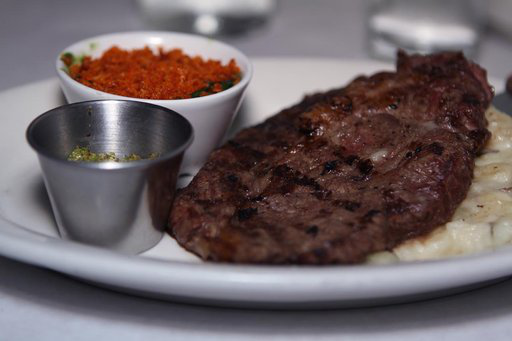

In [7]:
import random
from PIL import Image

# random.seed(42)

#Get all image path
image_path_list=list(image_path.glob("*/*/*.jpg"))
#Pick a random image path
random_image_path= random.choice(image_path_list)
#Get the image class form the path name(the image class is the name of the directory)
image_class= random_image_path.parent.stem
#Open image
img= Image.open(random_image_path)
#Print metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image heigh: {img.height} ")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 340.5, -0.5)

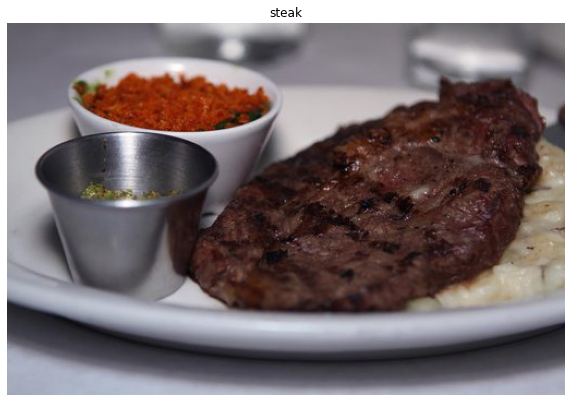

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into the array
img_as_array= np.asarray(img)
#Plot the image 
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(image_class)
plt.axis(False)

##Transforming data into tensor

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [10]:
data_transforms= transforms.Compose([
    #Resize the image into 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly
    transforms.RandomHorizontalFlip(p=0.5),
    #Trun the imgae to tensor
    transforms.ToTensor()
])

In [11]:
data_transforms(img).shape

torch.Size([3, 64, 64])

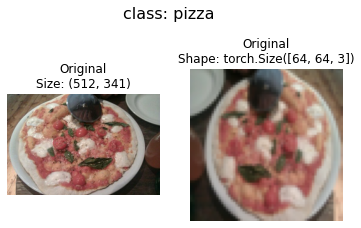

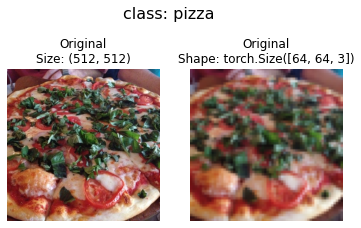

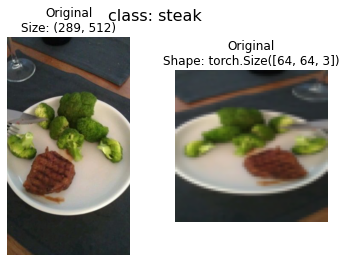

In [12]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n=3,
                            seed=None):
  if seed:
    random.seed(seed)
  random_image_paths= random.sample(image_paths, k=n) 
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2) 
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transfom and plot target image
      transformed_image = transform(f).permute(1,2,0) #(C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Original\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths= image_path_list,
                        transform = data_transforms,
                        n=3, seed=42)  

##Option 1: Loading image data using `torchvision.datasets.ImageFolder`

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(
    root= train_dir, 
    transform= data_transforms,
    target_transform= None
)
test_data= datasets.ImageFolder(
    root= test_dir,
    transform= data_transforms,
    target_transform= None
)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
#Get class names as list
class_names= train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
class_dict= train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
len(train_data), len(test_data)

(225, 75)